##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multimodal RAG using llamaindex and Gemini

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Multimodal_RAG_for_youtube_videos.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/>

## Overview

This notebook demonstrates how to build a multimodal retrieval system that can process and retrieve relevant information from both text and images of a youtube video using LlamaIndex and Gemini.

Having a visual context is important when some relevant text or information is on the slide/chart but not spoken.

In [1]:
%pip install -U -q "google-genai>=1.0.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.1 MB/s eta 0:00:00


## Installing the necessary libraries

In [ ]:
%pip install youtube-transcript-api
%pip install moviepy
%pip install yt_dlp

%pip install llama_index

#For using OpenAI's CLIP model for image embeddings
%pip install git+https://github.com/openai/CLIP.git
%pip install llama-index-embeddings-clip

#Transformers and PyTorch
%pip install transformers torch

#For using Hugging Face models to generate text embeddings
%pip install llama-index-embeddings-huggingface

#For using Qdrant as a local vector database
%pip install qdrant-client
%pip install llama_index.vector_stores.qdrant


## Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](../quickstarts/Authentication.ipynb) quickstart for an example.

In [26]:
from google.colab import userdata
from google import genai

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
client = genai.Client(api_key=GOOGLE_API_KEY)

## Step-by-step workflow for multimodal RAG


## Extract transcript with times stamps from the youtube video

You give a prompt to the gemini model to extract transcripts from the youtub video.

Then, you store the transcript as a text file in the contents folder.

In [5]:
video_url = "https://www.youtube.com/watch?v=wjZofJX0v4M"

In [6]:
MODEL_ID="gemini-2.0-flash" # @param ["gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-pro-exp-03-25"] {"allow-input":true, isTemplate: true}

In [7]:
from google.genai import types

def get_transcript(video_url):
  transcript = client.models.generate_content(
      model=MODEL_ID,
      contents=types.Content(
          parts=[
              types.Part(text="Extract the full transcript from this video"),
              types.Part(
                  file_data=types.FileData(file_uri=video_url)
              )
          ]
      )
  )
  return transcript.text

In [8]:
transcript=get_transcript(video_url)

In [9]:
print(transcript[:1000])

Okay, here's the requested transcript:

[00:00:00] The initials GPT stand for generative pre-trained transformer.
[00:00:05] So that first word is straightforward enough; these are bots that generate new text.
[00:00:09] Pre-trained refers to how the model went through a process of learning from a massive amount of data, and the prefix insinuates that there's more room to fine-tune it on specific tasks with additional training.
[00:00:20] But the last word, that's the real key piece: a Transformer is a specific kind of neural network, a machine learning model, and it's the core invention underlying the current boom in AI.
[00:00:31] What I want to do with this video, and the following chapters, is go through a visually driven explanation for what actually happens inside a transformer.
[00:00:39] We're going to follow the data that flows through it, and go step by step.
[00:00:43] There are many different kinds of models that you can build using Transformers.
[00:00:47] Some models take

In [10]:
import os

contents_folder = "./all_data/"
if not os.path.exists(contents_folder):
    os.makedirs(contents_folder)
with open(contents_folder + "transcript.txt", "w", encoding="utf-8") as file:
    file.write(transcript)

print("Transcript saved")


Transcript saved


## Extracting Frames from a Video

This extracts frames from a given video file at regular time intervals(here 1 frame per 5 seconds). The frames are saved as .jpg images in the specified output folder.

This prepares the dataset of images from which the images will be retrieved during RAG

In [11]:
import cv2
import yt_dlp as youtube_dl

with youtube_dl.YoutubeDL({}) as ydl:
    info = ydl.extract_info(video_url, download=False)
    duration = info['duration']
    for f in info['formats']:
        if f.get('format_note') == '144p' and f.get('vcodec') != 'none':
            stream_url = f['url']
            break

cap = cv2.VideoCapture(stream_url)
x = 0
for t in range(0, duration, 5):
    cap.set(cv2.CAP_PROP_POS_MSEC, t * 1000)
    ret, frame = cap.read()
    if ret:
        cv2.imwrite(f"all_data/image{x}.png", frame)
        x += 1

cap.release()
cv2.destroyAllWindows()
print(f"Extracted {x} frames")

[youtube] Extracting URL: https://www.youtube.com/watch?v=wjZofJX0v4M
[youtube] wjZofJX0v4M: Downloading webpage
[youtube] wjZofJX0v4M: Downloading tv client config
[youtube] wjZofJX0v4M: Downloading player 9599b765-main
[youtube] wjZofJX0v4M: Downloading tv player API JSON
[youtube] wjZofJX0v4M: Downloading ios player API JSON
[youtube] wjZofJX0v4M: Downloading m3u8 information
Extracted 327 frames


## Setting up the text embedding model

This configures a Hugging Face embedding model (BAAI/bge-small-en-v1.5) for text embeddings using llama_index.

Embedding models convert text into numerical vectors for efficient similarity search and retrieval.

#### NOTE : This below cell is optional since you are using a public model but it is always a better choice to authenticate.

To run the following cell, your hugging face access token must be stored in a Colab Secret named HF_TOKEN. If you don't already have the access token refer this [link](https://huggingface.co/docs/hub/en/security-tokens).

In [12]:
import os
from huggingface_hub import login

# Setting the Hugging Face token
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')
login(token=os.getenv('HF_TOKEN'))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [13]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings

Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5"
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Setting Up a MultiModal Vector Store

This initializes a MultiModal Vector Store Index using `Qdrant`, a vector database for storing and retrieving embeddings of both text and images. Even though they are two embeddings both are stored in the same vector space to enable efficient retrieval.

Steps followed -
- Create a local Qdrant database (local_db)

- Define separate stores for text and image embeddings

- Load extracted images and transcript from the `./all_data/ ` folder

- Build a MultiModal index to enable efficient retrieval of text and images

In [27]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index.core import SimpleDirectoryReader

# Create a local Qdrant vector store
qd_client = qdrant_client.QdrantClient(path="local_db")

# Below is the store for text embeddings
text_store = QdrantVectorStore(client=qd_client, collection_name="text_collection")

# Below is the store for image embeddings
image_store = QdrantVectorStore(client=qd_client, collection_name="image_collection")

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# this folder contains the extarcted images and transcriot
documents = SimpleDirectoryReader("./all_data/").load_data()

# Create the MultiModal index
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

## Creating the multi-modal retriever

This code converts the multi-modal index into a retriever engine, allowing retrieval of the top 5 most similar text and image embeddings based on the query. This enables searching across both text and images efficiently.

The number can be changed as per preference.

In [28]:
retriever_engine = index.as_retriever(
    similarity_top_k=5, image_similarity_top_k=5
)

## Retrieving relevant text and images.

 It takes a query and uses the retriever engine to fetch the most relevant text and images. If the retrieved node is an image, its file path is stored, while for text nodes, the first 200 characters are displayed along with the similarity score.

In [29]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode


def retrieve(retriever_engine, query):
    retrieval_results = retriever_engine.retrieve(query)

    retrieved_images = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_images.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_images, retrieved_text

### Function to make the retrieval based on the query

In [30]:
def make_retrieval(query):
    image_paths, text = retrieve(retriever_engine=retriever_engine, query=query)
    image_documents = SimpleDirectoryReader(
        input_dir=contents_folder, input_files=image_paths
    ).load_data()
    text_context = "".join(text)
    return image_paths, text_context


### Function to display the top 5 images retrieved

In [31]:
import matplotlib.pyplot as plt
import cv2

def display_images(image_paths):
    images = [cv2.imread(path) for path in image_paths]
    plt.figure(figsize=(10, 7))

    for i, image in enumerate(images):
        plt.subplot(2, 3, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis("off")

    plt.show()

## Uploading images

Next, upload images to Gemini, which takes an image path and uploads it. Finally, all five images are uploaded storing their references for generating responses.

In [32]:
def upload_to_gemini(path, mime_type="image/jpeg"):
    file = client.files.upload(file = path)
    return file

## Constructing a well-structured prompt

You define the prompt for the model, instructing it to analyze both text and image context to generate a comprehenssive response.

The prompt also instructs the model to return "could not find an answer" if relevant information in not available.

In [33]:
def create_prompt(text_context, query, files):
    prompt = [
        "You are an expert LLM model with the ability to process both text and images. Using the provided information:",
        "- Refer to the context provided in the text and the visual details in the images to answer the query comprehensively.",
        "- Be precise and detailed in your response, drawing insights from both the text and images.",
        "- If an explanation requires referencing images, do so explicitly.",
        "",
        f"Text Context:\n{text_context}\n",
        "Images: Provided in image_context\n",
        f"Query:\n{query}\n",
        "If you cannot find an answer, reply with 'could not find answer'. Avoid giving gibberish responses.",
        *files,
    ]
    return prompt


### Function to process the query and generate response

In [55]:
def process_query_and_generate_response(query_str):
    image_paths, text_context = make_retrieval(query_str)
    print(image_paths)
    print("\n\n")
    print("Retrieved Text Context (First 500 characters):\n")
    print(text_context[:500])
    print("\n\n")

    print("Displaying Retrieved Images:\n")
    display_images(image_paths)
    print("\n\n")

    files = [upload_to_gemini(path) for path in image_paths]
    print("\n\n")

    prompt = create_prompt(text_context, query_str, files)

    response = client.models.generate_content(
    model=MODEL_ID,
      contents=prompt,
    )
    return response


 ### Example Query 1

In [62]:
query1 = "What does the linear regression graph in the video indicate. Mention in detail?"
# refer to 0.58s

**Node ID:** e5f87c3d-fd48-4c1e-8d35-708a134ae122<br>**Similarity:** 0.6837917761177329<br>**Text:** [03:04] Let's kick things off with a very high level preview of how data flows through a Transformer.
[03:08] We will spend much more time motivating and interpreting and expanding on the details o...<br>

**Node ID:** adae5b5d-52e0-4c28-83fa-e8be06678b99<br>**Similarity:** 0.6794254743451893<br>**Text:** [06:22] and then you have it start predicting what such a helpful AI assistant would say in response.
[06:35] There is more to say about an added step of training that's required to make this work ...<br>

**Node ID:** d55c6001-1067-4285-b9fd-9f57f6a45c40<br>**Similarity:** 0.6645243200982145<br>**Text:** Okay, here's the requested transcript:

[00:00:00] The initials GPT stand for generative pre-trained transformer.
[00:00:05] So that first word is straightforward enough; these are bots that genera...<br>

['/content/all_data/image102.png', '/content/all_data/image103.png', '/content/all_data/image101.png', '/content/all_data/image106.png', '/content/all_data/image149.png']



Retrieved Text Context (First 500 characters):

[03:04] Let's kick things off with a very high level preview of how data flows through a Transformer.
[03:08] We will spend much more time motivating and interpreting and expanding on the details of each step, but in broad strokes, when one of these chatbots generates a given word, here's what's going on under the hood.
[03:19] First, the input is broken up into a bunch of little pieces.
[03:22] These pieces are called tokens, and in the case of text, these tend to be words or little pieces of w



Displaying Retrieved Images:



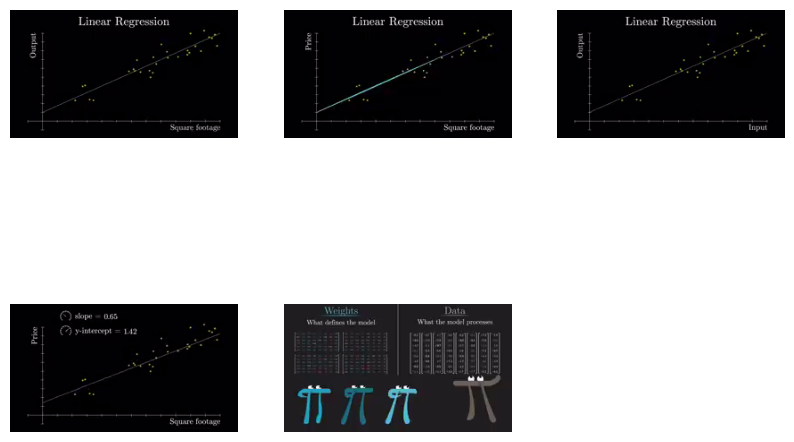

In [63]:
response = process_query_and_generate_response(query1)

In this below response you can clearly realize that it has extracted data from both text and images.
Not everything in the response generated is spoken, some things are written on the one of the images extracted.

This shows the importance of requiring visual context to generate accurate responses.

In [64]:
import textwrap
print(textwrap.fill(response.text, width=100))

Referring to the image titled "Linear Regression", the graph illustrates a linear regression model.
The data points are scattered around a line, and the goal of linear regression is to determine the
parameters of that line (slope and y-intercept) to closely match the data. As shown in the "Linear
Regression" image with the slope and y-intercept values, slope is equal to 0.65 and the y-intercept
is 1.42.


### Example query 2

In [65]:
query2 = "What is the reference shown about quill? Elaborate on it"
# refer to 19.07 of the video

**Node ID:** d55c6001-1067-4285-b9fd-9f57f6a45c40<br>**Similarity:** 0.5603491981115567<br>**Text:** Okay, here's the requested transcript:

[00:00:00] The initials GPT stand for generative pre-trained transformer.
[00:00:05] So that first word is straightforward enough; these are bots that genera...<br>

**Node ID:** e5f87c3d-fd48-4c1e-8d35-708a134ae122<br>**Similarity:** 0.5491414079813067<br>**Text:** [03:04] Let's kick things off with a very high level preview of how data flows through a Transformer.
[03:08] We will spend much more time motivating and interpreting and expanding on the details o...<br>

**Node ID:** adae5b5d-52e0-4c28-83fa-e8be06678b99<br>**Similarity:** 0.5280313679346689<br>**Text:** [06:22] and then you have it start predicting what such a helpful AI assistant would say in response.
[06:35] There is more to say about an added step of training that's required to make this work ...<br>

['/content/all_data/image230.png', '/content/all_data/image242.png', '/content/all_data/image43.png', '/content/all_data/image82.png', '/content/all_data/image168.png']



Retrieved Text Context (First 500 characters):

Okay, here's the requested transcript:

[00:00:00] The initials GPT stand for generative pre-trained transformer.
[00:00:05] So that first word is straightforward enough; these are bots that generate new text.
[00:00:09] Pre-trained refers to how the model went through a process of learning from a massive amount of data, and the prefix insinuates that there's more room to fine-tune it on specific tasks with additional training.
[00:00:20] But the last word, that's the real key piece: a Transform



Displaying Retrieved Images:



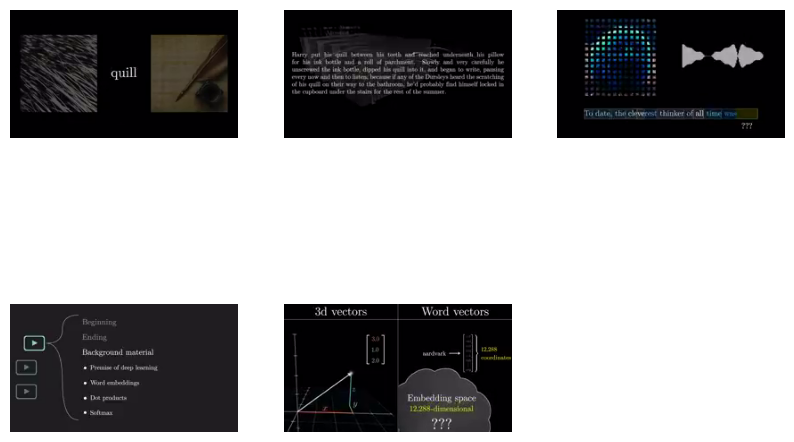

In [66]:
response = process_query_and_generate_response(query2)

The word 'quill' is never spoken by the speaker but the model is able to extract information becasue of the images retrieved.

In [67]:
print(textwrap.fill(response.text, width=100))

Based on the image, there is a reference to a "quill". In the image, there is a visual of a quill
and ink. Also, it shows an example sentence: "Harry put his quill between his teeth and reached
underneath his pillow for his ink bottle and a roll of parchment. Slowly and very carefully he
unscrewed the ink bottle, dipped his quill into it, and began to write, pausing every now and then
to listen, because if any of the Dursleys heard the scratching of his quill on their way to the
bathroom, he'd probably find himself locked in the cupboard under the stairs for the rest of the
summer."


## Next Steps
### Useful documentation references:
To improve your prompting skills check the [prompt guide](https://ai.google.dev/gemini-api/docs/prompting-strategies
)

Now that you've learnt to create a multiodal RAG use you own youtube video and test with different queries and see the wonders!

### Continue your discovery of the Gemini API
To learn more about gemini embeddings you can refer to these links - [embeddings overview](https://ai.google.dev/gemini-api/docs/embeddings) and [embeddings quickstart](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Embeddings.ipynb)